In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pyodbc 
from sklearn.dummy import DummyClassifier

In [56]:
#going to use a random 15k for the training data set , may increase the size later

server = 'hvs-ssis5,1433'
database = 'common' # enter database name
cnxn=pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=Yes')

predictit_data = pd.read_sql("""SELECT top 30000 * from predictit_matched_20240206 order by newid()""", cnxn)

cnxn.close()

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_6104\3098035179.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  predictit_data = pd.read_sql("""SELECT top 30000 * from predictit_matched_20240206 order by newid()""", cnxn)


# Data Pre-Processing Steps

In [57]:
#keep only the active users

for column in ['deposits', 'accountbalance', 'Withdrawals', 'Invested', 'riskamount', 'profit', 'loss','numshares']:
    predictit_data[column] = pd.to_numeric(predictit_data[column])
    
condition = (
    (predictit_data['deposits'] != 0) |
    (predictit_data['accountbalance'] != 0) |
    (predictit_data['Withdrawals'] != 0.00) |
    (predictit_data['Invested'] != 0.00) |
    (predictit_data['numshares'] != 0) |  
    (predictit_data['riskamount'] != 0.0000) |
    (predictit_data['profit'] != 0.000000) |
    (predictit_data['loss'] != 0.000000)
)

predictit_data = predictit_data[condition].copy()

In [58]:
# add a winner column with 1 where profit > loss , 0 otherwise this will be our target variable
predictit_data['winner'] = (predictit_data['profit'] + predictit_data['loss']) > 0
predictit_data['winner'] = predictit_data['winner'].astype(int)



In [60]:
len(predictit_data)
predictit_data['winner'].value_counts()

0    13654
1     6312
Name: winner, dtype: int64

## create a balanced data set

In [61]:
winners = predictit_data[predictit_data['winner'] == 1]
losers = predictit_data[predictit_data['winner'] == 0]

# Sample 6000 instances from each subset
winners_sample = winners.sample(n=6000, random_state=42, replace=False)
losers_sample = losers.sample(n=6000, random_state=42, replace=False)

# Combine the samples to form a balanced dataset
balanced_dataset = pd.concat([winners_sample, losers_sample])

# Shuffle the dataset to ensure a mix of classes
predictit_data = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)


In [62]:
len(predictit_data)

12000

## feature engineering

In [63]:
#Replace blanks and spaces with NaN
predictit_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#consolidate SEX values due to some casing issues.
predictit_data['SEX'] = predictit_data['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})

# Mapping the PARTY_CODE to new groups
party_code_mapping = {
    'R': 'Republican', 'S': 'Republican',
    'D': 'Democrat', 'E': 'Democrat',
    'N': 'No Affiliation', 'U': 'Unknown'
}

# If the party code is not in the mapping, assign 'O' (other)
predictit_data['GROUPED_PARTY'] = predictit_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')




C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_6104\2521844727.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictit_data['GROUPED_PARTY'] = predictit_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')


In [64]:
# Convert numeric fields to float
for column in predictit_data.columns:
    # Check if all values in the column are numeric
    if predictit_data[column].apply(lambda x: str(x).replace('.', '', 1).isdigit()).all():
        predictit_data[column] = predictit_data[column].astype(float)
    # Check for fields where the only values are 'Y' and NaN
    elif set(predictit_data[column].dropna().unique()) == {'Y'}:
        predictit_data[column] = predictit_data[column].map({'Y': 1, np.nan: 0}).astype(int)
        predictit_data[column] = predictit_data[column].astype(float)

In [65]:
#impute missing values

for column in predictit_data.columns:
    # Check if the column is numeric
    if predictit_data[column].dtype in ['float64', 'int64']:
        # Impute missing values with median
        median_val = predictit_data[column].median()
        predictit_data[column].fillna(median_val, inplace=True)
    else:
        # Impute missing values with mode
        mode_val = predictit_data[column].mode().iloc[0]
        predictit_data[column].fillna(mode_val, inplace=True)

C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

In [66]:
#fill any columns that are all empty with 0
for column in predictit_data.columns:
    # Check if all values in the column are NaN
    if predictit_data[column].isna().all():
        predictit_data[column] = predictit_data[column].fillna(0)

## split data into target variable and features

I am going to train using some of the features identified as likely being important during the data explorations and visualation work

In [67]:

features_to_use = ['PASSPROSVAL','MEDHOMEVAL','AUTO_MSRP','ZIP','VTR_PPP84','VTR_PRI87','CNS_MEDINC','TOD_GOV_D_2020',
'TOD_GOV_R_2020','TOD_GOV_D_2012','TOD_GOV_R_2012','VTR_PRI88','TOD_GOV_R_2016','TOD_GOV_D_2016','VTR_PRI86',
'TOD_PRES_R_2020_PREC','TOD_PRES_R_2016_PREC','AUTO_MODEL','TOD_SEN_O_2012','TOD_GOV_DIFF_2020','TOD_PRES_D_2020_PREC',
'TOD_GOV_DIFF_2016','TOD_GOV_DIFF_2012','OCCDETAIL_DESC','OCCDETAIL','VTR_PPP88','TOD_PRES_D_2016_PREC',
'TOD_SEN_R_2014','TOD_SEN_D_2020','TOD_SEN_R_2020','PRFL_POLITICAL_IDEOLOGY','TOD_SEN_D_2014','PREVIOUS_PARTY',
'PARTY_CODE','TOD_GOV_D_2018','GROUPED_PARTY','TOD_SEN_D_2012','TOD_SEN_R_2016','TOD_GOV_O_2016','TOD_SEN_R_2012',
'TOD_GOV_R_2018','ALUMNI_INDUSTRY','TOD_PRES_D_2016','TOD_PRES_R_2020','PARTY_MIX','ETHNIC_INFER','INCOMESTHH']
 
X = predictit_data[features_to_use] 
y = predictit_data['winner']

In [68]:
#first split - validation set
X_temp, X_validation, y_temp, y_validation = train_test_split(X, y, test_size=0.1, random_state=42) # 10% for validation

#Second split: Splitting the remaining data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42) # 20% of 90% for testing

## label encoding for categorical columns

In [69]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [70]:
# Initialize the label encoders dictionary
label_encoders = {}

# Encoding each categorical column in the training set and applying it to test and validation sets
for col in categorical_columns:
    # Initialize the LabelEncoder
    le = LabelEncoder()

    # Fit on the training data
    le.fit(X_train[col].astype(str))

    # Transform training, test, and validation data using the fitted encoder
    # Unseen categories in test and validation sets are replaced with -1
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = X_test[col].map(lambda s: le.transform([str(s)]) if str(s) in le.classes_ else -1).astype(int)
    X_validation[col] = X_validation[col].map(lambda s: le.transform([str(s)]) if str(s) in le.classes_ else -1).astype(int)

    # Store the LabelEncoder for later use
    label_encoders[col] = le


In [71]:
X_train.head()

,PASSPROSVAL,MEDHOMEVAL,AUTO_MSRP,ZIP,VTR_PPP84,VTR_PRI87,CNS_MEDINC,TOD_GOV_D_2020,TOD_GOV_R_2020,TOD_GOV_D_2012,...,TOD_SEN_R_2016,TOD_GOV_O_2016,TOD_SEN_R_2012,TOD_GOV_R_2018,ALUMNI_INDUSTRY,TOD_PRES_D_2016,TOD_PRES_R_2020,PARTY_MIX,ETHNIC_INFER,INCOMESTHH
7591,287,1710,0,92139.0,0.0,1,1531,153,3,156,...,2,32,175,110,45,375,104,2.0,3,14
381,3668,1154,1230,60558.0,0.0,1,1263,153,3,156,...,22,32,43,26,45,459,31,4.0,2,18
2935,287,1710,0,6897.0,0.0,1,1531,153,3,156,...,56,32,181,125,45,387,91,3.0,2,14
9380,4115,1679,1175,60521.0,0.0,1,1465,153,3,156,...,118,32,43,132,45,358,125,1.0,2,18
3769,693,1710,0,40217.0,0.0,1,313,153,3,156,...,83,32,43,26,45,360,118,1.0,2,4


In [72]:
#train a dummy classifier

dummy_clf = DummyClassifier(strategy='most_frequent')

# Train the DummyClassifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy of DummyClassifier: {accuracy}')

Baseline accuracy of DummyClassifier: 0.4976851851851852


In [ ]:
#ok so we have dummy classifier baseline accuracy of about 50%

In [82]:
#initialize and train logistic regression model
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
lr_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lr_pipeline.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.5634259259259259
              precision    recall  f1-score   support

         0.0       0.57      0.55      0.56      1085
         1.0       0.56      0.58      0.57      1075

    accuracy                           0.56      2160
   macro avg       0.56      0.56      0.56      2160
weighted avg       0.56      0.56      0.56      2160



In [83]:
# Perform 10-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(lr_pipeline, X_train, y_train, cv=10, scoring=scoring)

# Print the average of the evaluation metrics across all 10 folds
print("10-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

10-Fold Cross-Validation Results:
Average Accuracy: 0.573
Average Precision (macro): 0.574
Average F1-Score (macro): 0.573


In [84]:
#validation set testing
y_validation_pred = lr_pipeline.predict(X_validation)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.555
              precision    recall  f1-score   support

         0.0       0.57      0.54      0.55       613
         1.0       0.54      0.57      0.56       587

    accuracy                           0.56      1200
   macro avg       0.56      0.56      0.55      1200
weighted avg       0.56      0.56      0.55      1200



In [ ]:
#ok so logistic regression is a little better than the dummy classifier. let's try a few others.

In [76]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
#rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
rf_pipeline = RandomForestClassifier()
rf_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Model Test Set Evaluation:
Accuracy: 0.5370370370370371
              precision    recall  f1-score   support

         0.0       0.54      0.56      0.55      1085
         1.0       0.54      0.51      0.52      1075

    accuracy                           0.54      2160
   macro avg       0.54      0.54      0.54      2160
weighted avg       0.54      0.54      0.54      2160



In [77]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosted Decision Tree model
#gbdt_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gbdt_pipeline =  GradientBoostingClassifier()
gbdt_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_gbdt = gbdt_pipeline.predict(X_test)
print("Gradient Boosted Decision Tree Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))

Gradient Boosted Decision Tree Model Test Set Evaluation:
Accuracy: 0.5546296296296296
              precision    recall  f1-score   support

         0.0       0.57      0.45      0.50      1085
         1.0       0.54      0.66      0.60      1075

    accuracy                           0.55      2160
   macro avg       0.56      0.56      0.55      2160
weighted avg       0.56      0.55      0.55      2160



In [79]:
import xgboost as xgb

# Initialize and train the XGBoost model
# Note: XGBClassifier handles data scaling internally, so StandardScaler is not necessary.
xgb_pipeline = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Model Test Set Evaluation:
Accuracy: 0.5564814814814815
              precision    recall  f1-score   support

         0.0       0.56      0.52      0.54      1085
         1.0       0.55      0.59      0.57      1075

    accuracy                           0.56      2160
   macro avg       0.56      0.56      0.56      2160
weighted avg       0.56      0.56      0.56      2160



The other models are all around 55%

In [85]:
# Get predictions for each model
prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
prob_gbdt = gbdt_pipeline.predict_proba(X_test)[:, 1]
prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Average the probabilities
average_prob = (prob_xgb + prob_gbdt + prob_rf + prob_lr) / 4

# Convert probabilities to final predictions based on a threshold, e.g., 0.5
final_predictions = np.where(average_prob > 0.5, 1, 0)

# Evaluate the ensemble model
print("Ensemble Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))

Ensemble Model Test Set Evaluation:
Accuracy: 0.5699074074074074
              precision    recall  f1-score   support

         0.0       0.58      0.53      0.55      1085
         1.0       0.56      0.61      0.59      1075

    accuracy                           0.57      2160
   macro avg       0.57      0.57      0.57      2160
weighted avg       0.57      0.57      0.57      2160



In [ ]:
#ensemble approach is only a tiny improvement

## feature importances

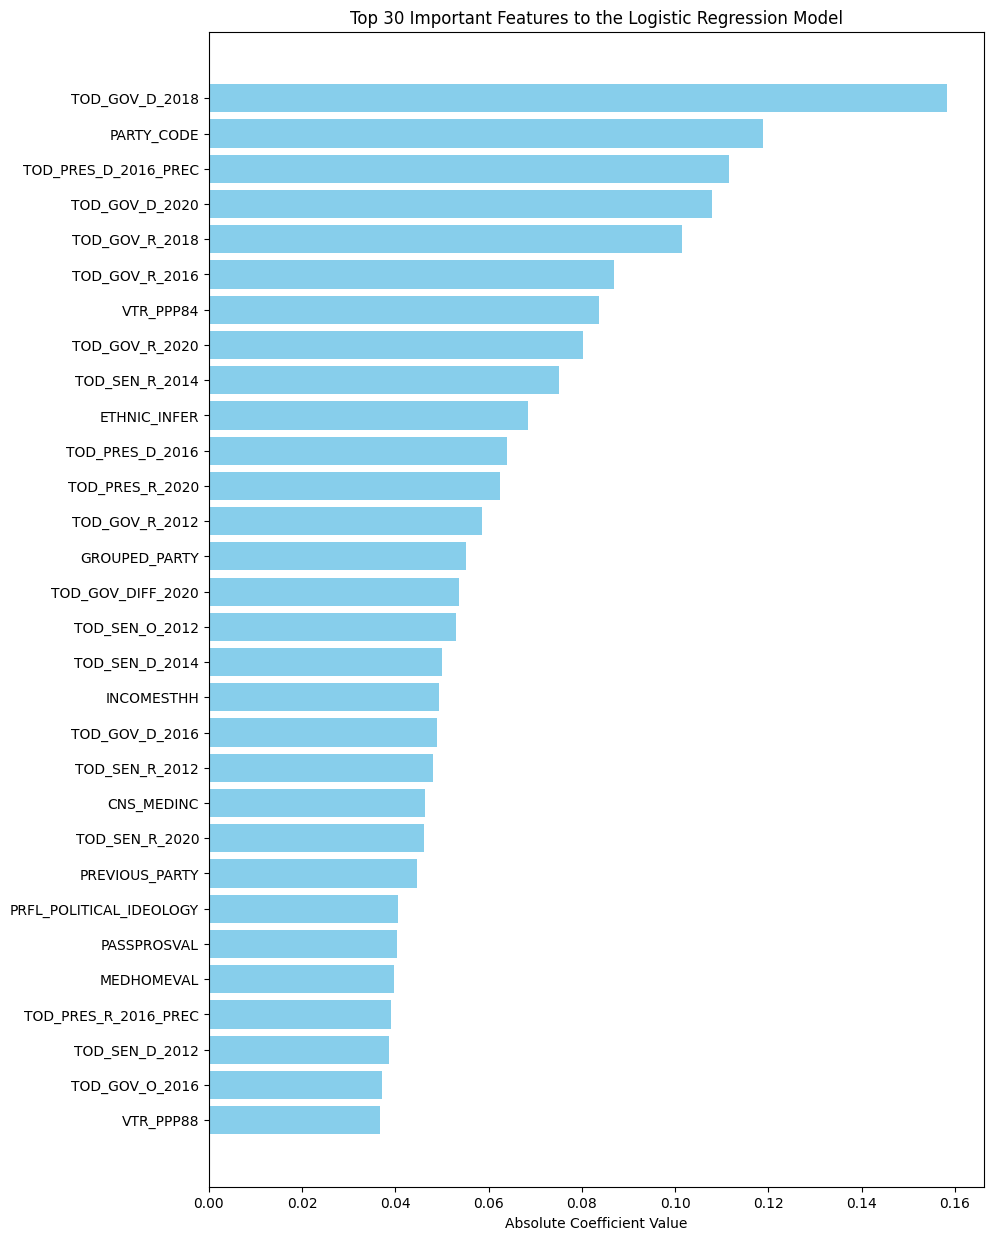

In [86]:
#feature importance

X = X.copy()

for col, le in label_encoders.items():
    if col in X.columns:
        # Directly modify the DataFrame column
        X[col] = X[col].apply(lambda s: le.transform([str(s)]) if str(s) in le.classes_ else -1).astype(int)

# Fit the Logistic Regression pipeline to the full training data
lr_pipeline.fit(X, y)  #  X and y are the full training features and labels without the validation set

# Get the feature names and coefficients
feature_names = X.columns
coefficients = pipeline.named_steps['logisticregression'].coef_.flatten()  # Extract the coefficients

# Create a DataFrame of features and their corresponding coefficients
feature_importance = pd.DataFrame(data={'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute values of the coefficients to determine their "importance"
feature_importance['Importance'] = feature_importance['Coefficient'].abs()

# Sort the data by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the top features
top_features = feature_importance.head(30)
plt.figure(figsize=(10, 15))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 30 Important Features to the Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert the Y-axis to have the most important feature on top
plt.show()
